In [1]:
import tensorflow as tf
import keras

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

### Dataset preparation for the classifiers

In [17]:
CLASS_NAMES = [
    "ADI",
    "BACK",
    "DEB",
    "LYM",
    "MUC",
    "MUS",
    "NORM",
    "STR",
    "TUM",
]

train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../NCT-CRC-HE-small-5k-per-class",
    labels="inferred",
    label_mode="categorical",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.30,
    subset="both",
)

Found 45000 files belonging to 9 classes.
Using 31500 files for training.
Using 13500 files for validation.


In [15]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../CRC-VAL-HE-7K",
    labels="inferred",
    label_mode="categorical",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
)

Found 7180 files belonging to 9 classes.


### Classifiers

https://keras.io/api/applications/

#### ResNet50

In [21]:
# create base model without fine-tuning the weights
base_model = keras.applications.ResNet50(
    weights=None, input_shape=(224, 224, 3), include_top=False
)

# add a global spatial average pooling layer
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)

# add a fully-connected layer
x = keras.layers.Dense(1024, activation="relu")(x)

# add a logistic layer
predictions = keras.layers.Dense(9, activation="softmax")(x)

# this is the model we will train
model_resnet50 = keras.models.Model(inputs=base_model.input, outputs=predictions)

# fine-tune the model
model_resnet50.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy", "AUC", "Precision", "Recall"],
)

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='resnet50_model/checkpoint_{epoch:02d}.h5',
        monitor='val_loss',
        verbose=0,
        save_best_only=True,
        mode='auto',
        save_freq='epoch',
        options=None,
        initial_value_threshold=None
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=5,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=True
    ),
]

# train the model
history_resnet50 = model_resnet50.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=callbacks_list,
)

Epoch 1/25
985/985 [==============================] - 275s 274ms/step - loss: 0.9108 - accuracy: 0.6863 - auc: 0.9513 - precision: 0.7905 - recall: 0.5905 - val_loss: 3.3122 - val_accuracy: 0.3541 - val_auc: 0.7478 - val_precision: 0.3652 - val_recall: 0.3340
Epoch 2/25
985/985 [==============================] - 263s 267ms/step - loss: 0.4193 - accuracy: 0.8556 - auc: 0.9870 - precision: 0.8821 - recall: 0.8276 - val_loss: 4.2910 - val_accuracy: 0.3173 - val_auc: 0.7148 - val_precision: 0.3244 - val_recall: 0.3027
Epoch 3/25
985/985 [==============================] - 262s 266ms/step - loss: 0.2739 - accuracy: 0.9089 - auc: 0.9936 - precision: 0.9229 - recall: 0.8954 - val_loss: 3.9700 - val_accuracy: 0.2764 - val_auc: 0.6845 - val_precision: 0.2911 - val_recall: 0.2619
Epoch 4/25
985/985 [==============================] - 263s 267ms/step - loss: 0.2374 - accuracy: 0.9209 - auc: 0.9948 - precision: 0.9328 - recall: 0.9117 - val_loss: 2.8614 - val_accuracy: 0.3596 - val_auc: 0.7713 - val

In [9]:
model_resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

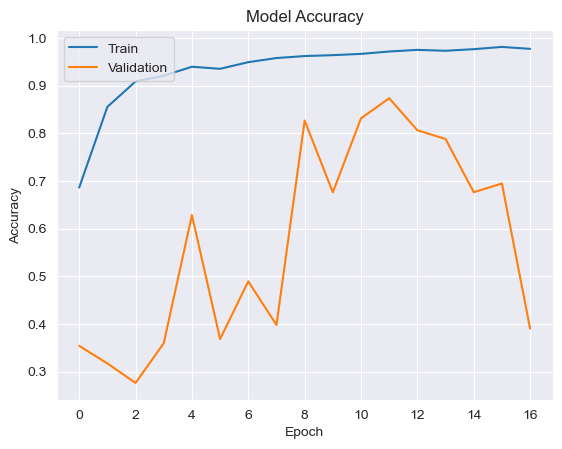

In [22]:
plt.plot(history_resnet50.history["accuracy"])
plt.plot(history_resnet50.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

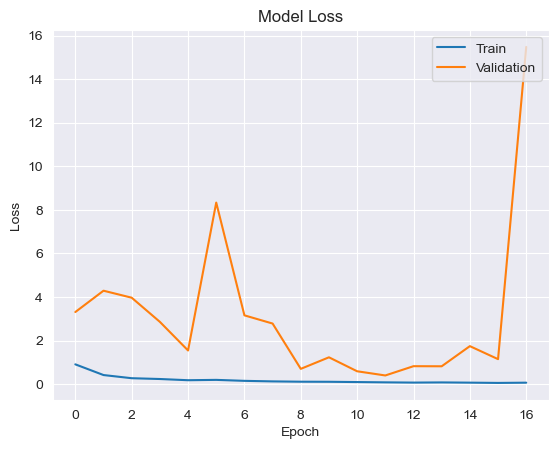

In [23]:
# display loss
plt.plot(history_resnet50.history["loss"])
plt.plot(history_resnet50.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()

In [24]:
model_resnet50.evaluate(test_ds)

225/225 [==============================] - 18s 81ms/step - loss: 0.9197 - accuracy: 0.7462 - auc: 0.9550 - precision: 0.7543 - recall: 0.7366


[0.9197218418121338,
 0.7462395429611206,
 0.9550003409385681,
 0.7542783617973328,
 0.7366295456886292]

In [25]:
model_resnet50.evaluate(train_ds)

985/985 [==============================] - 77s 78ms/step - loss: 0.3513 - accuracy: 0.8828 - auc: 0.9894 - precision: 0.8935 - recall: 0.8756


[0.35134169459342957,
 0.8828253746032715,
 0.9893797636032104,
 0.8934598565101624,
 0.8756190538406372]

In [14]:
model_resnet50.save("../models/resnet_scratch_50_12.h5")

#### VGG16

In [14]:
base_model_vgg = tf.keras.applications.VGG16(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False) 

# freeze the base model
base_model_vgg.trainable = False

# create a new model on top
inputs = keras.Input(shape=(224, 224, 3))
x = base_model_vgg(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(9, activation="softmax")(x)
model_vgg = keras.Model(inputs, outputs)

# fine-tune the model
model_vgg.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy", "AUC", "Precision", "Recall"],
)

# train the model
history_vgg = model_vgg.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
)

58889256/58889256 [==============================] - 22s 0us/step
Epoch 1/10
138/138 [==============================] - 26s 183ms/step - loss: 1.5789 - accuracy: 0.6143 - auc: 0.8980 - precision: 0.6587 - recall: 0.5846 - val_loss: 0.7886 - val_accuracy: 0.7672 - val_auc: 0.9614 - val_precision: 0.7965 - val_recall: 0.7497
Epoch 2/10
138/138 [==============================] - 25s 178ms/step - loss: 0.5106 - accuracy: 0.8447 - auc: 0.9801 - precision: 0.8655 - recall: 0.8256 - val_loss: 0.5648 - val_accuracy: 0.8397 - val_auc: 0.9770 - val_precision: 0.8612 - val_recall: 0.8243
Epoch 3/10
138/138 [==============================] - 24s 176ms/step - loss: 0.3756 - accuracy: 0.8755 - auc: 0.9885 - precision: 0.8917 - recall: 0.8628 - val_loss: 0.4799 - val_accuracy: 0.8619 - val_auc: 0.9813 - val_precision: 0.8784 - val_recall: 0.8487
Epoch 4/10
138/138 [==============================] - 24s 177ms/step - loss: 0.2901 - accuracy: 0.9029 - auc: 0.9921 - precision: 0.9167 - recall: 0.8907 - v

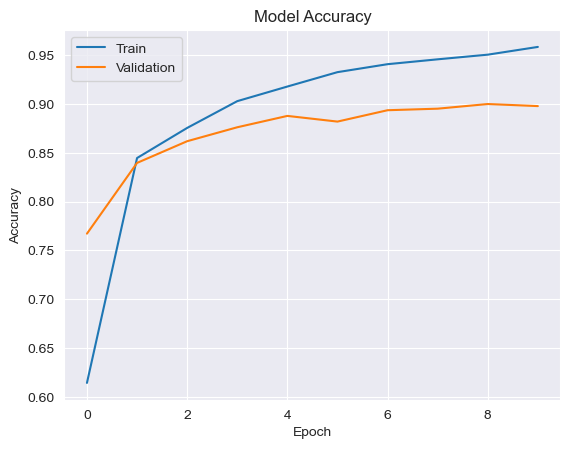

In [15]:
plt.plot(history_vgg.history["accuracy"])
plt.plot(history_vgg.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

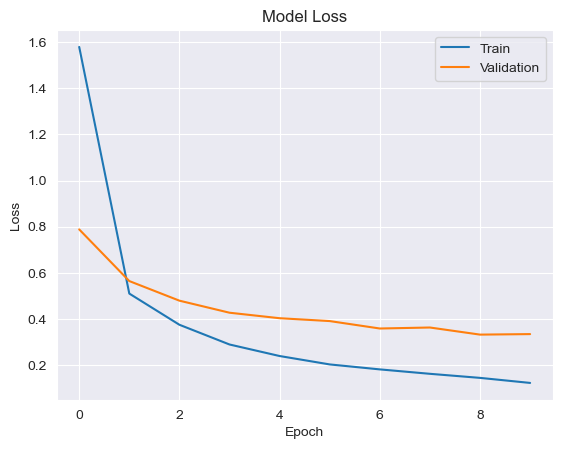

In [17]:
plt.plot(history_vgg.history["loss"])
plt.plot(history_vgg.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()

In [18]:
model_vgg.save("models/vgg_16_10e.h5")

In [22]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "CRC-VAL-HE-7K",
    labels="inferred",
    label_mode="categorical",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
)

model.evaluate(test_ds)

Found 7180 files belonging to 9 classes.
225/225 [==============================] - 18s 81ms/step - loss: 0.3652 - accuracy: 0.8648 - auc: 0.9897 - precision: 0.8788 - recall: 0.8522


[0.3651573956012726,
 0.8647632598876953,
 0.9897357821464539,
 0.8787878751754761,
 0.8522284626960754]

#### DenseNet121

In [5]:
base_model_densenet121 = tf.keras.applications.DenseNet121(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False
)

# freeze the base model
base_model_densenet121.trainable = False

# create a new model on top
inputs = keras.Input(shape=(224, 224, 3))

x = base_model_densenet121(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(9, activation="softmax")(x)
model_densenet121 = keras.Model(inputs, outputs)

# fine-tune the model
model_densenet121.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy", "AUC", "Precision", "Recall"],
)

# train the model
history_densenet121 = model_densenet121.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
)


Epoch 1/10
138/138 [==============================] - 24s 150ms/step - loss: 1.7980 - accuracy: 0.5315 - auc: 0.8638 - precision: 0.6150 - recall: 0.4608 - val_loss: 0.9886 - val_accuracy: 0.6582 - val_auc: 0.9412 - val_precision: 0.7362 - val_recall: 0.5656
Epoch 2/10
138/138 [==============================] - 15s 111ms/step - loss: 0.8258 - accuracy: 0.7084 - auc: 0.9576 - precision: 0.7806 - recall: 0.6308 - val_loss: 0.8954 - val_accuracy: 0.6794 - val_auc: 0.9506 - val_precision: 0.7716 - val_recall: 0.6042
Epoch 3/10
138/138 [==============================] - 15s 108ms/step - loss: 0.6777 - accuracy: 0.7642 - auc: 0.9699 - precision: 0.8247 - recall: 0.6975 - val_loss: 0.6911 - val_accuracy: 0.7556 - val_auc: 0.9688 - val_precision: 0.8132 - val_recall: 0.6794
Epoch 4/10
138/138 [==============================] - 15s 107ms/step - loss: 0.5840 - accuracy: 0.7948 - auc: 0.9770 - precision: 0.8512 - recall: 0.7356 - val_loss: 0.6341 - val_accuracy: 0.7751 - val_auc: 0.9727 - val_pre

In [8]:
model_densenet121.evaluate(test_ds)

225/225 [==============================] - 18s 80ms/step - loss: 0.6977 - accuracy: 0.7685 - auc: 0.9685 - precision: 0.8150 - recall: 0.7233


[0.6976847648620605,
 0.7685236930847168,
 0.9684514999389648,
 0.8149717450141907,
 0.7232590913772583]

In [9]:
model_densenet121.save("models/densenet_121_10e.h5")

#### EfficientNetB0

In [12]:
base_model_efficientnetb0 = tf.keras.applications.EfficientNetB0(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False
)

# freeze the base model
base_model_efficientnetb0.trainable = False

# create a new model on top
inputs = keras.Input(shape=(224, 224, 3))

x = base_model_efficientnetb0(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(9, activation="softmax")(x)
model_efficientnetb0 = keras.Model(inputs, outputs)

# fine-tune the model
model_efficientnetb0.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy", "AUC", "Precision", "Recall"],
)

# train the model
history_convnext = model_efficientnetb0.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
)

16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/10
138/138 [==============================] - 24s 137ms/step - loss: 0.8067 - accuracy: 0.7748 - auc: 0.9685 - precision: 0.9428 - recall: 0.5569 - val_loss: 0.4605 - val_accuracy: 0.8656 - val_auc: 0.9891 - val_precision: 0.9216 - val_recall: 0.7836
Epoch 2/10
138/138 [==============================] - 10s 73ms/step - loss: 0.3663 - accuracy: 0.8921 - auc: 0.9931 - precision: 0.9354 - recall: 0.8338 - val_loss: 0.3554 - val_accuracy: 0.8894 - val_auc: 0.9925 - val_precision: 0.9251 - val_recall: 0.8434
Epoch 3/10
138/138 [==============================] - 11s 76ms/step - loss: 0.2852 - accuracy: 0.9134 - auc: 0.9955 - precision: 0.9459 - recall: 0.8798 - val_loss: 0.3128 - val_accuracy: 0.9026 - val_auc: 0.9934 - val_precision: 0.9346 - val_recall: 0.8693
Epoch 4/10
138/138 [==============================] - 10s 74ms/step - loss: 0.2448 - accuracy: 0.9274 - auc: 0.9967 - precision: 0.9522 - recall: 0.8995 - val_l

### Classifiers performance summary and comparison

In [18]:
vgg16_finetuned_10e = keras.models.load_model("models/vgg_16_10e.h5")
resnet50_finetuned_10e = keras.models.load_model("models/resnet_50_10e.h5")
densenet121_finetuned_10e = keras.models.load_model("models/densenet_121_10e.h5")

225/225 [==============================] - 18s 78ms/step - loss: 0.6977 - accuracy: 0.7685 - auc: 0.9685 - precision: 0.8150 - recall: 0.7233


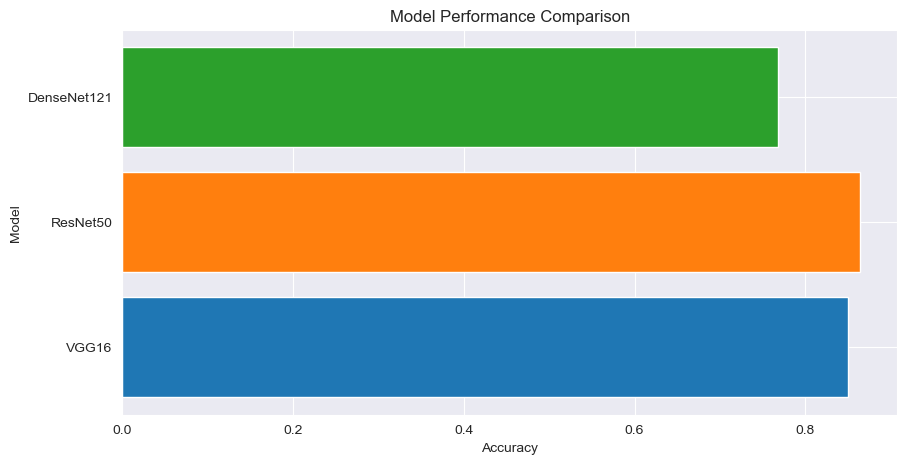

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


sns.set_style("darkgrid")

models = [vgg16_finetuned_10e, resnet50_finetuned_10e, densenet121_finetuned_10e]
model_names = ["VGG16", "ResNet50", "DenseNet121"]

results = []

for model in models:
    results.append(model.evaluate(test_ds))

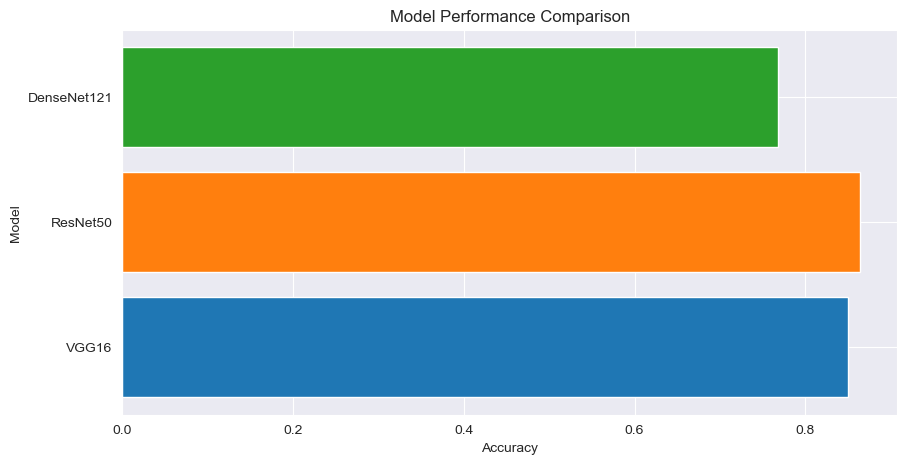

In [24]:
plt.figure(figsize=(10, 5))
plt.title("Model Performance Comparison")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.barh(model_names, [result[1] for result in results], color=["#1f77b4", "#ff7f0e", "#2ca02c"])
plt.show()